In [11]:
from inspect import getfullargspec, signature
from itertools import product, chain

import pandas as pd
from joblib import delayed, wrap_non_picklable_objects, Parallel
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import (
    make_scorer,
    get_scorer,
    confusion_matrix,
    recall_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from tqdm import tqdm
from functools import reduce
from operator import or_

from experiments.util import DataLoader
from experiments.util import ResultHandler
from skpsl import ProbabilisticScoringList
from skpsl.preprocessing.binarizer import MinEntropyBinarizer
from skpsl.metrics import expected_entropy_loss, weighted_loss, soft_ranking_loss


In [12]:
# RESULTFOLDER = "experimentsresults"
DATAFOLDER = "experiments/data"

In [13]:
X, y = DataLoader(DATAFOLDER).load("thorax")


experiments/data/thorax.csv


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [15]:
def conservative_weighted_loss(y_true, y_prob, m=10, *, sample_weight=None):
    lb, ub = y_prob.T
    tn, fp, fn, tp = confusion_matrix(
        y_true, 1 - ub < m * ub, sample_weight=sample_weight, normalize="all"
    ).ravel()
    return fp + m * fn


In [19]:
losses_in = []
losses_out = []
stages = []
psl_pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy="most_frequent"),
    ProbabilisticScoringList(score_set=set(list(range(-3,4)))),
).fit(X_train, y_train)

psl = psl_pipeline[1]
for k, stage in enumerate(psl):
    if k == 0:
        continue

    X_train_ = X_train[:, stage.features]
    X_test_ = X_test[:, stage.features]

    clf_pipeline = make_pipeline(
        SimpleImputer(missing_values=-1, strategy="most_frequent"),
        xgb.XGBClassifier(**{'max_depth': 5, 'learning_rate': 0.08278264552785686, 'n_estimators': 97, 'subsample': 0.741171103114342, 'gamma': 0.470929356727593}),
    ).fit(X_train_, y_train)

    y_proba_out = clf_pipeline.predict_proba(X_test_)
    y_proba_in = clf_pipeline.predict_proba(X_train_)
    stages.append(k)
    losses_out.append(conservative_weighted_loss(y_test, y_proba_out, m=10))
    losses_in.append(conservative_weighted_loss(y_train, y_proba_in, m=10))

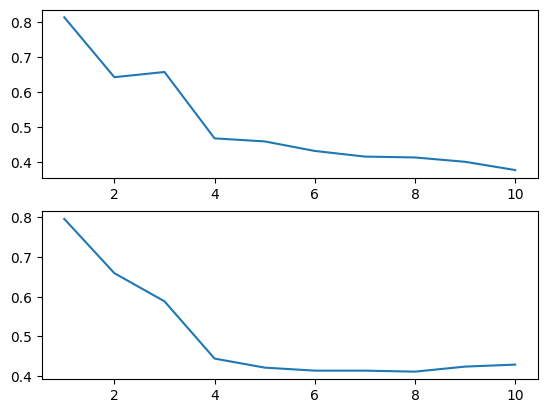

In [20]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2)
axes[0].plot(stages,losses_in)
axes[1].plot(stages,losses_out)

In [18]:
import optuna
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np

psl_pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy="most_frequent"),
    ProbabilisticScoringList(score_set=set(list(range(-3,4)))),
).fit(X_train, y_train)

psl = psl_pipeline[1]

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5)
    }

    losses_out = []
    losses_in = []

    for k, stage in enumerate(psl):
        if k == 0:
            continue

        X_train_ = X_train[:, stage.features]
        X_test_ = X_test[:, stage.features]

        clf_pipeline = make_pipeline(
            SimpleImputer(missing_values=-1, strategy="most_frequent"),
            xgb.XGBClassifier(**param),
        ).fit(X_train_, y_train)

        y_proba_out = clf_pipeline.predict_proba(X_test_)
        y_proba_in = clf_pipeline.predict_proba(X_train_)
        stages.append(k)
        losses_out.append(conservative_weighted_loss(y_test, y_proba_out, m=10))
        losses_in.append(conservative_weighted_loss(y_train, y_proba_in, m=10))

    return np.mean(losses_out).item()



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)



[I 2024-09-12 15:17:15,461] A new study created in memory with name: no-name-03edc7ae-bb0a-4531-b113-d03e53bf8fdd
[I 2024-09-12 15:17:16,758] Trial 0 finished with value: 0.5277777777777779 and parameters: {'max_depth': 10, 'learning_rate': 0.03971945286739296, 'n_estimators': 285, 'subsample': 0.7288102028777939, 'gamma': 0.19734838906509328}. Best is trial 0 with value: 0.5277777777777779.
[I 2024-09-12 15:17:17,698] Trial 1 finished with value: 0.5186868686868686 and parameters: {'max_depth': 8, 'learning_rate': 0.028556436715021907, 'n_estimators': 298, 'subsample': 0.9556442397026034, 'gamma': 0.4572896501877388}. Best is trial 1 with value: 0.5186868686868686.
[I 2024-09-12 15:17:18,395] Trial 2 finished with value: 0.5199494949494949 and parameters: {'max_depth': 7, 'learning_rate': 0.1294072297976842, 'n_estimators': 220, 'subsample': 0.8179544327430673, 'gamma': 0.4058892906845712}. Best is trial 1 with value: 0.5186868686868686.
[I 2024-09-12 15:17:18,836] Trial 3 finished wi

KeyboardInterrupt: 

In [ ]:
print("Best parameters found: ", study.best_params)


Best parameters found:  {'max_depth': 4, 'learning_rate': 0.2783043321800373, 'n_estimators': 84, 'subsample': 0.6008639429753931, 'gamma': 0.4611811408482283}
